# 1 - Querying top miner UID

In [ ]:
import bittensor as bt

USE_TESTNET=True

if USE_TESTNET:
    metagraph = bt.metagraph(netuid=118, network="test")
else:
    metagraph = bt.metagraph(netuid=2, network="finney")

top_miner_uid = int(metagraph.incentive.argmax())
print(top_miner_uid)


# 2 - Demonstration of Rewards

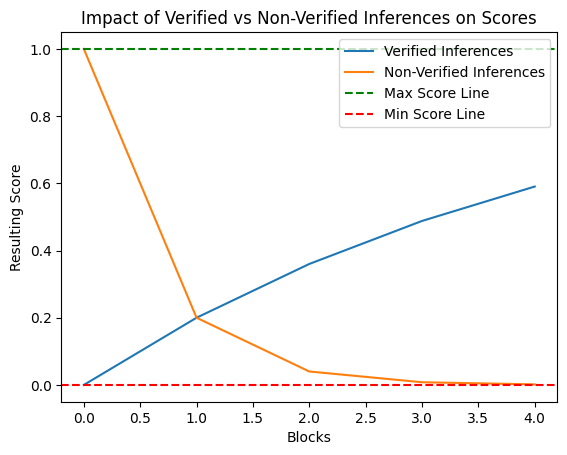

In [1]:
from _validator.reward import reward

try:
    import matplotlib
except ImportError:
    %pip install matplotlib

from matplotlib import pyplot as plt

# Miner responds with a proven inference

assert reward(1, 0.5, True, 1) == 0.6

# Miner responds with a non-verified inference

assert reward(1, 0.5, False, 1) < 0.1

initial_score = 0
proven_values = [initial_score] + [initial_score := reward( 1, initial_score, True, 1) for _ in range(4)]
initial_score = 1
non_verified_values = [initial_score] + [ initial_score := reward( 1, initial_score, False, 1) for _ in range(4)]

plt.plot([i for i in range(5)], proven_values, label='Verified Inferences')
plt.plot([i for i in range(5)], non_verified_values, label='Non-Verified Inferences')
plt.axhline(y=1, color='g', linestyle='--', label='Max Score Line')
plt.axhline(y=0, color='r', linestyle='--', label='Min Score Line')
plt.xlabel('Blocks')
plt.ylabel('Resulting Score')
plt.title('Impact of Verified vs Non-Verified Inferences on Scores')
plt.legend()
plt.show()


# 3 - N/A